In [3]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import tensorflow.keras as kr

from IPython.display import clear_output

# Posibles cambios: 
# eliminar el normalize de [-1, 1] de las imagenes. Mantener rango [0, 255]
# eliminar bias de las capas convolucionales si se realiza batch normalization despues

In [4]:
# RETRIEIVING IMAGE FILENAMES FROM GOOGLE DRIVE (remember to syncr Colab with Drive first)

FLOWER_PATH = "/content/drive/MyDrive/flowers"
EDITED_PATH = "/content/drive/MyDrive/flowers_BW"
CHECKPOINT_PATH = "/content/drive/MyDrive/GAN_results"

flower_filenames = !ls -1 {FLOWER_PATH} # Returns a list with all filenames of the images from the path
flower_filenames = np.copy(flower_filenames) #converts list format into NumPy array
np.random.shuffle(flower_filenames) # randomization of the retrieved list

n = 4300 # number of images used among the total database
n_train = round(n * 0.80) # Percentage of images used for training

training_filenames = flower_filenames[:n_train]
test_filenames = flower_filenames[n_train:n]

print("Number of randomized images used for training: " + str(training_filenames.shape[0]))
print("Number of randomized images used for test: " + str(test_filenames.shape[0]))


Number of randomized images used for training: 3440
Number of randomized images used for test: 860


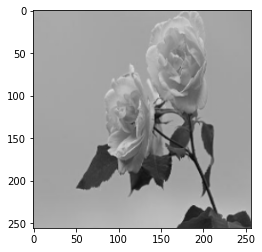

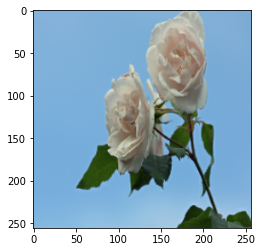

Filename: 7865295712_bcc94d120c.jpg


In [5]:
# LOADING IMAGES

def read_image(filename):

  input_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(EDITED_PATH + "/" + filename), channels=3), tf.float32)
  target_image = tf.cast(tf.image.decode_jpeg(tf.io.read_file(FLOWER_PATH + "/" + filename), channels=3), tf.float32)

  return input_image, target_image


def resize(input_image, target_image, height, width):

  input_image = tf.image.resize(input_image, [height, width])
  target_image = tf.image.resize(target_image, [height, width])

  return input_image, target_image


# To randomly generate modified images from the existing ones. Helps to increase the dataset collection artificially
def random_jitter(input_image, target_image):

  input_image, target_image = resize(input_image, target_image, 286, 286) # Dim = [286, 286, 3], [286, 286, 3]
  stacked_images = tf.stack([input_image, target_image]) # Puts one image over the other to apply the same crops to both. Dim = [2, 286, 286, 3]
  cropped_images = tf.image.random_crop(stacked_images, [2, 256, 256, 3])

  input_image = cropped_images[0]
  target_image = cropped_images[1]

  if tf.random.uniform(()) > 0.5: # 50% chance to flip both images
    input_image = tf.image.flip_left_right(input_image)
    target_image =tf.image.flip_left_right(target_image)
  
  return input_image, target_image


 # To reescale values to range [-1, 1] (computation more stable than range [0, 255])
def normalize(input_image, target_image): 

  input_image = (input_image /127.5) - 1
  target_image = (target_image / 127.5) - 1

  return input_image, target_image


def load_training_image(filename):

  input_image, target_image = read_image(filename)
  input_image, target_image = resize(input_image, target_image, 256, 256)
  input_image, target_image = random_jitter(input_image, target_image) 
  input_image, target_image = normalize(input_image, target_image)

  return input_image, target_image

# # doesn't include the random_jitter function (we don't want to change the image we want to predict))
def load_test_image(filename):

  input_image, target_image = read_image(filename)
  input_image, target_image = resize(input_image, target_image, 256, 256)
  input_image, target_image = normalize(input_image, target_image)

  return input_image, target_image

example = load_training_image(training_filenames[0])

plt.imshow((example[0] + 1) / 2) # plt.imshow only reads rangs [0, 1], and our image has rang [-1, 1]
plt.show()
plt.imshow((example[1] + 1) / 2)
plt.show()

print("Filename: " + str(training_filenames[0]))


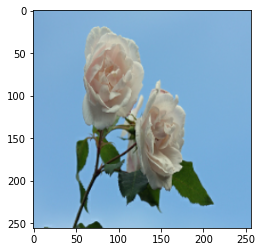

In [6]:
# DATASETS CREATION

train_dataset = tf.data.Dataset.from_tensor_slices(training_filenames)
train_dataset = train_dataset.map(load_training_image, tf.data.AUTOTUNE) # tf.data.AUTOTUNE automatically sets the nº of available threads to use to increase efficiency
train_dataset = train_dataset.batch(1) # Organizes the dataset in batches of 1 pairs of images (input_image, target_image)

test_dataset = tf.data.Dataset.from_tensor_slices(test_filenames)
test_dataset = test_dataset.map(load_test_image, tf.data.AUTOTUNE) 
test_dataset = test_dataset.batch(1) 

for input_image, target_image in train_dataset.take(1):

  plt.imshow((target_image[0] + 1) / 2)
  plt.show()


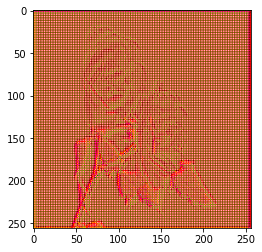

In [7]:

# U_NET ARCHITECTURE

def encoder_block(num_filters, batch_norm = True):

  result = kr.Sequential() # Indication to Keras that the "result" object will be a combination of layers

  # Convolution layer
  result.add(kr.layers.Conv2D(num_filters,
                              kernel_size = 4,
                              strides = 2,
                              kernel_initializer = tf.random_normal_initializer(0, 0.02),
                              padding="same")) # maintains the dimension of the characterisic maps while are passing through the convolution filters
                              
  if batch_norm == True:
    # Batch normalization layer (Normalizes the values in the matrix given by the previous layer)
    result.add(kr.layers.BatchNormalization()) 
  
  # Activation function layer
  result.add(kr.layers.LeakyReLU(alpha=0.2)) 

  return result


def decoder_block(num_filters, dropout = True):

  result = kr.Sequential() 

  # Deconvolution layer
  result.add(kr.layers.Conv2DTranspose(num_filters,
                                      kernel_size = 4,
                                      strides = 2,
                                      kernel_initializer = tf.random_normal_initializer(0, 0.02),
                                      padding="same")) 
  
  # Batch normalization layer
  result.add(kr.layers.BatchNormalization()) 

  if dropout == True:
    # Dropout layer (randomly inhabilitates some nodes from the previous layer to prevent overfitting)
    result.add(kr.layers.Dropout(0.5)) 

  # Activation function layer
  result.add(kr.layers.ReLU()) 

  return result


def UNetGenerator(): # Definition of Keras Model

  input_layer = kr.layers.Input(shape = [256, 256, 3])  # dim [batch_size, 256, 256, 3]

  # The first block doesn't include a batch normalization layer
  encoder = [
    encoder_block(64, batch_norm = False),  # dim [batch_size, 128, 128, 64]
    encoder_block(128),                     # dim [batch_size, 64, 64, 128]
    encoder_block(256),                     # dim [batch_size, 32, 32, 256]
    encoder_block(512),                     # dim [batch_size, 16, 16, 512]
    encoder_block(512),                     # dim [batch_size, 8, 8, 512]
    encoder_block(512),                     # dim [batch_size, 4, 4, 512]
    encoder_block(512),                     # dim [batch_size, 2, 2, 512]
    encoder_block(512),                     # dim [batch_size, 1, 1, 512]
  ]

  # From block nº4 onwards the dropout layer doesn't apply
  decoder = [
    decoder_block(512),                     # dim [batch_size, 2, 2, 512]
    decoder_block(512),                     # dim [batch_size, 4, 4, 512]
    decoder_block(512),                     # dim [batch_size, 8, 8, 512]
    decoder_block(512, dropout = False),    # dim [batch_size, 16, 16, 512]
    decoder_block(256, dropout = False),    # dim [batch_size, 32, 32, 256]
    decoder_block(128, dropout = False),    # dim [batch_size, 64, 64, 128]
    decoder_block(64, dropout = False),     # dim [batch_size, 128, 128, 64]
  ]


  last_layer = kr.layers.Conv2DTranspose(filters = 3,
                                      kernel_size = 4,
                                      strides = 2,
                                      kernel_initializer = tf.random_normal_initializer(0, 0.02),
                                      padding="same",
                                      activation = "tanh") # Images values in range [0, 1]


  # Union of each block to form a U_Net architecture (encoder + decoder, where each block contains a skip connection with its equivalent in reverse (example first-last))
  x = input_layer
  skip_connections = []

  for block in encoder:

    x = block(x)
    skip_connections.append(x) # Saving of the outputs of each block of the encoder to use them as skip connections in the decoder forloop

  skip_connections = reversed(skip_connections[:-1]) # the skip connection of the last encoder block is not needed (duplicated path)
  
  for block, s in zip(decoder, skip_connections):
 
    x = block(x)
    x = kr.layers.concatenate([x, s], axis = 3) # Creation of skip connections. The input of the next loop will be the concatenation (addition) of x and its corresponding skip_connection

  x = last_layer(x)

  return kr.Model(inputs = input_layer, outputs = x)

generator = UNetGenerator() # Creation of an object based on the previous Keras model
generated_image = generator(((input_image+1)*255), training = True) #MIRAR
plt.imshow((generated_image[0]+1)/2) 



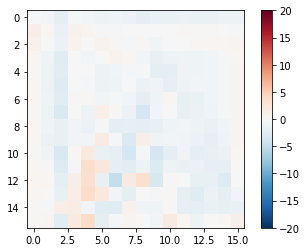

In [8]:
# DISCRIMINATOR ARCHITECTURE

def Discriminator(): # Keras Model

  target_image = kr.layers.Input(shape = [256, 256, 3]) 
  generated_image = kr.layers.Input(shape = [256, 256, 3]) 

  x = kr.layers.concatenate([target_image, generated_image], axis = 3)

  x = encoder_block(64, batch_norm = False)(x)
  x = encoder_block(128)(x)
  x = encoder_block(256)(x)
  x = encoder_block(512)(x)
  x = kr.layers.Conv2DTranspose(filters = 1,
                                kernel_size = 4,
                                strides = 1,
                                kernel_initializer = tf.random_normal_initializer(0, 0.02),
                                padding="same")(x)

  return(kr.Model(inputs = [target_image, generated_image], outputs = x))
                
discriminator = Discriminator()
discr_image = discriminator([(target_image+1)*255, (generated_image+1)*255], training =True)
plt.imshow(discr_image[0,:,:,0], vmin=-20, vmax=20, cmap="RdBu_r")
plt.colorbar()




In [9]:
# FUNCTION COST FOR DISCRIMINATOR AND GENERATOR

lossp = kr.losses.BinaryCrossentropy(from_logits=True) # Keras Object. from_logits normalizes the image inputs to range[0,1]

def dicriminator_loss(discr_target_image, discr_generated_image):
  
  loss1 = lossp(tf.ones_like(discr_target_image), discr_target_image)
  loss2 = lossp(tf.zeros_like(discr_generated_image), discr_generated_image)

  loss = loss1 + loss2

  return loss

alpha = 100


def generator_loss(discr_generated_image, generated_image, target_image):
  
  loss1 = lossp(tf.ones_like(discr_generated_image), discr_generated_image)
  loss2 = tf.reduce_mean(tf.abs(target_image - generated_image))

  loss = loss1 + (alpha * loss2)

  return loss

In [10]:
generator_optimizer = kr.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # Parameters that appear in the paper
discriminator_optimizer = kr.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

def train_step(input_image, target_image):

  #gen_tape = tf.GradientTape()
  #discr_tape = tf.GradientTape()

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

    generated_image = generator(((input_image+1))*255, training = True)

    discr_generated_image = discriminator([(input_image+1)*255, (generated_image+1)*255], training = True)

    discr_target_image = discriminator([(input_image+1)*255, (target_image+1)*255], training = True)

    discr_loss = dicriminator_loss(discr_target_image, discr_generated_image)

    gen_loss = generator_loss(discr_generated_image, generated_image, target_image)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_gradients = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [11]:
import os

checkpoint_prefix = os.path.join(CHECKPOINT_PATH, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH))#.assert_consumed()

In [12]:
def test(model, input_image):

  prediction = model((input_image+1)*255, training =True)

  plt.figure(figsize=(10,10))

  display_list = [input_image[0], prediction[0]]
  title = ["Input image", "Predicted Image"]

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow((display_list[i]+1)/2)
    plt.axis("off")
  
  plt.show()  
  time.sleep(3)

In [24]:
def train(train_dataset, test_dataset, epochs, model):

  for epoch in range(epochs):

    i = 0

    for input_image, target_image in train_dataset:

      print("Epoch: " + str(epoch) + "  Train: " + str(i) + "/" + str(len(training_filenames)))
      i += 1
      train_step(input_image, target_image) # pendiente de implementar
      clear_output(wait = True)
    
    test_dataset = test_dataset.shuffle(1, reshuffle_each_iteration=True)
    for input_image, target_image in test_dataset.take(1):

      test(model, input_image)
      
    if epoch % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

In [14]:
# train(train_dataset, test_dataset, 100, generator)

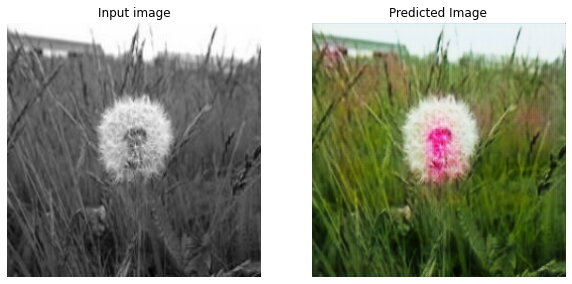

In [27]:
test_dataset = test_dataset.shuffle(1, reshuffle_each_iteration=True)

for input_image, target_image in test_dataset.take(1):

  test(generator, input_image)